### 一.过拟合
建模的目的是让模型学习到数据的一般性规律，但有时候可能会学过头，学到一些噪声数据的特性，虽然模型可以在训练集上取得好的表现，但在测试集上结果往往会变差，这时称模型陷入了**过拟合**，接下来造一些伪数据进行演示：

In [2]:
import os
os.chdir('../')
from ml_models.linear_model import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#造伪样本
X=np.linspace(0,100,100)
X=np.c_[X,np.ones(100)]
w=np.asarray([3,2])
Y=X.dot(w)
X=X.astype('float')
Y=Y.astype('float')
X[:,0]+=np.random.normal(size=(X[:,0].shape))*3#添加噪声
Y=Y.reshape(100,1)

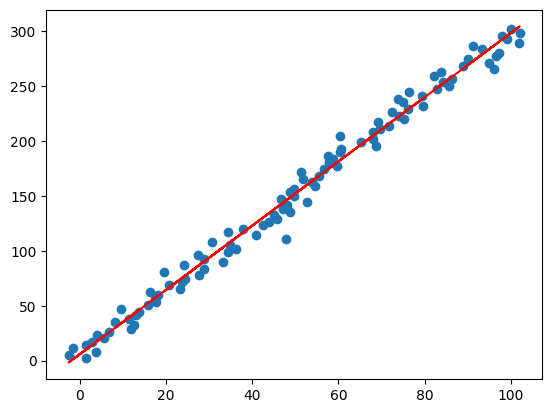

In [4]:
#拟合数据并可视化
lr=LinearRegression()
lr.fit(X[:,:-1],Y)
lr.plot_fit_boundary(X[:,:-1],Y)

目前看起来效果还是可以的，但如果加入几个异常点，再看看效果呢

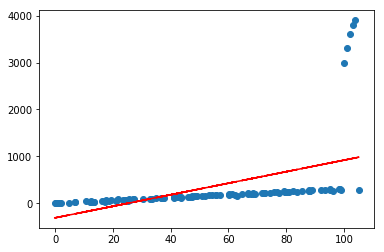

In [4]:
X=np.concatenate([X,np.asanyarray([[100,1],[101,1],[102,1],[103,1],[104,1]])])
Y=np.concatenate([Y,np.asanyarray([[3000],[3300],[3600],[3800],[3900]])])
lr=LinearRegression()
lr.fit(X[:,:-1],Y)
lr.plot_fit_boundary(X[:,:-1],Y)

### 二.正则化
可以看到，仅仅加入了几个很离谱的异常点，就会对预测产生很大的影响，且偏离很远，这在实际情况中是很常见的；通常可以通过对模型参数添加正则化约束来避免这种情况，使其不会太“飘”，做法是在loss函数中为权重$w$添加$L_1$或者$L_2$约束，借用上一节的公式推导，直接推出loss部分：  

1.线性回归中添加$L_1$约束称为Lasso回归，其损失函数如下：  
$$
L(w)=\sum_{i=1}^m(y_i-f(x_i))^2+\lambda||w||_1
$$  
2.线性回归中添加$L_2$约束称为Ridge回归，其损失函数如下：  
$$
L(w)=\sum_{i=1}^m(y_i-f(x_i))^2+\alpha||w||_2
$$ 
3.如果不太确定用$L_1$好，还是$L_2$好，可以用它们的组合，称作ElasticNet，损失函数如下：  
$$
L(w)=\sum_{i=1}^m(y_i-f(x_i))^2+\lambda||w||_1+\alpha||w||_2
$$ 
可以发现通过调整超参，可以控制$w$的大小，如果$\lambda$或$\alpha$设置很大，$w$会被约束的很小，而如果$\alpha$或$\lambda$设置为0，等价于原始的不带正则项的线性回归；通常可以通过交叉验证，根据验证集上的表现来设置一个合适的超参；接下来在上一节线性回归代码的基础上实现Lasso,Ridge,ElasticNet模型，另外设置两个参数`l1_ratio`以及`l2_ratio`，分别用来控制$L_1$和$L_2$的loss部分的权重
### 三.代码实现

In [5]:
class LinearRegression(object):
    def __init__(self, fit_intercept=True, solver='sgd', if_standard=True, epochs=10, eta=1e-2, batch_size=1,
                 l1_ratio=None, l2_ratio=None):
        """
        :param fit_intercept: 是否训练bias
        :param solver:
        :param if_standard:
        """
        self.w = None
        self.fit_intercept = fit_intercept
        self.solver = solver
        self.if_standard = if_standard
        if if_standard:
            self.feature_mean = None
            self.feature_std = None
        self.epochs = epochs
        self.eta = eta
        self.batch_size = batch_size
        self.l1_ratio = l1_ratio
        self.l2_ratio = l2_ratio
        # 注册sign函数
        self.sign_func = np.vectorize(utils.sign)

    def init_params(self, n_features):
        """
        初始化参数
        :return:
        """
        self.w = np.random.random(size=(n_features, 1))

    def _fit_closed_form_solution(self, x, y):
        """
        直接求闭式解
        :param x:
        :param y:
        :return:
        """
        if self.l1_ratio is None and self.l2_ratio is None:
            self.w = np.linalg.pinv(x).dot(y)
        elif self.l1_ratio is None and self.l2_ratio is not None:
            self.w = np.linalg.inv(x.T.dot(x) + self.l2_ratio * np.eye(x.shape[1])).dot(x.T).dot(y)
        else:
            self._fit_sgd(x, y)

    def _fit_sgd(self, x, y):
        """
        随机梯度下降求解
        :param x:
        :param y:
        :param epochs:
        :param eta:
        :param batch_size:
        :return:
        """
        x_y = np.c_[x, y]
        # 按batch_size更新w,b
        for _ in range(self.epochs):
            np.random.shuffle(x_y)
            for index in range(x_y.shape[0] // self.batch_size):
                batch_x_y = x_y[self.batch_size * index:self.batch_size * (index + 1)]
                batch_x = batch_x_y[:, :-1]
                batch_y = batch_x_y[:, -1:]

                dw = -2 * batch_x.T.dot(batch_y - batch_x.dot(self.w)) / self.batch_size

                # 添加l1和l2的部分
                dw_reg = np.zeros(shape=(x.shape[1] - 1, 1))
                if self.l1_ratio is not None:
                    dw_reg += self.l1_ratio * self.sign_func(self.w[:-1]) / self.batch_size
                if self.l2_ratio is not None:
                    dw_reg += 2 * self.l2_ratio * self.w[:-1] / self.batch_size
                dw_reg = np.concatenate([dw_reg, np.asarray([[0]])], axis=0)
                dw += dw_reg
                self.w = self.w - self.eta * dw

    def fit(self, x, y):
        # 是否归一化feature
        if self.if_standard:
            self.feature_mean = np.mean(x, axis=0)
            self.feature_std = np.std(x, axis=0) + 1e-8
            x = (x - self.feature_mean) / self.feature_std
        # 是否训练bias
        if self.fit_intercept:
            x = np.c_[x, np.ones_like(y)]
        # 初始化参数
        self.init_params(x.shape[1])
        # 训练模型
        if self.solver == 'closed_form':
            self._fit_closed_form_solution(x, y)
        elif self.solver == 'sgd':
            self._fit_sgd(x, y)

    def get_params(self):
        """
        输出原始的系数
        :return: w,b
        """
        if self.fit_intercept:
            w = self.w[:-1]
            b = self.w[-1]
        else:
            w = self.w
            b = 0
        if self.if_standard:
            w = w / self.feature_std.reshape(-1, 1)
            b = b - w.T.dot(self.feature_mean.reshape(-1, 1))
        return w.reshape(-1), b

    def predict(self, x):
        """
        :param x:ndarray格式数据: m x n
        :return: m x 1
        """
        if self.if_standard:
            x = (x - self.feature_mean) / self.feature_std
        if self.fit_intercept:
            x = np.c_[x, np.ones(shape=x.shape[0])]
        return x.dot(self.w)

    def plot_fit_boundary(self, x, y):
        """
        绘制拟合结果
        :param x:
        :param y:
        :return:
        """
        plt.scatter(x[:, 0], y)
        plt.plot(x[:, 0], self.predict(x), 'r')

### Lasso

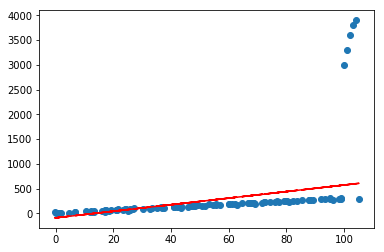

In [6]:
lasso=LinearRegression(l1_ratio=100)
lasso.fit(X[:,:-1],Y)
lasso.plot_fit_boundary(X[:,:-1],Y)

### Ridge

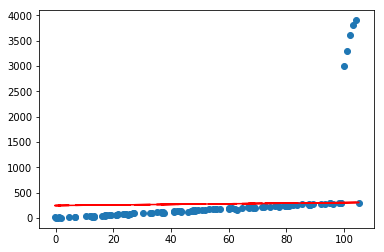

In [7]:
ridge=LinearRegression(l2_ratio=10)
ridge.fit(X[:,:-1],Y)
ridge.plot_fit_boundary(X[:,:-1],Y)

### ElasticNet

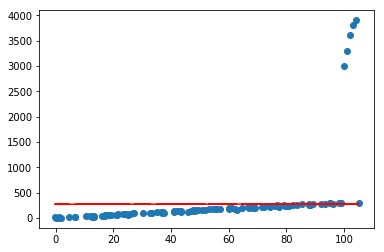

In [8]:
elastic=LinearRegression(l1_ratio=100,l2_ratio=10)
elastic.fit(X[:,:-1],Y)
elastic.plot_fit_boundary(X[:,:-1],Y)

将sign函数整理到ml_models.utils中